Epoch 0, Training Accuracy: 0.1550, Training Error: 0.2523, Validation Loss: 0.5539
Epoch 100, Training Accuracy: 0.2313, Training Error: 0.1701, Validation Loss: 0.4731
Epoch 200, Training Accuracy: 0.3187, Training Error: 0.1570, Validation Loss: 0.4601
Epoch 300, Training Accuracy: 0.3625, Training Error: 0.1507, Validation Loss: 0.4536
Epoch 400, Training Accuracy: 0.3825, Training Error: 0.1456, Validation Loss: 0.4485
Epoch 500, Training Accuracy: 0.4125, Training Error: 0.1408, Validation Loss: 0.4438
Epoch 600, Training Accuracy: 0.4450, Training Error: 0.1361, Validation Loss: 0.4392
Epoch 700, Training Accuracy: 0.4863, Training Error: 0.1314, Validation Loss: 0.4347
Epoch 800, Training Accuracy: 0.5200, Training Error: 0.1269, Validation Loss: 0.4304
Epoch 900, Training Accuracy: 0.5400, Training Error: 0.1230, Validation Loss: 0.4267
Epoch 1000, Training Accuracy: 0.5725, Training Error: 0.1196, Validation Loss: 0.4237
Epoch 1100, Training Accuracy: 0.5750, Training Error: 

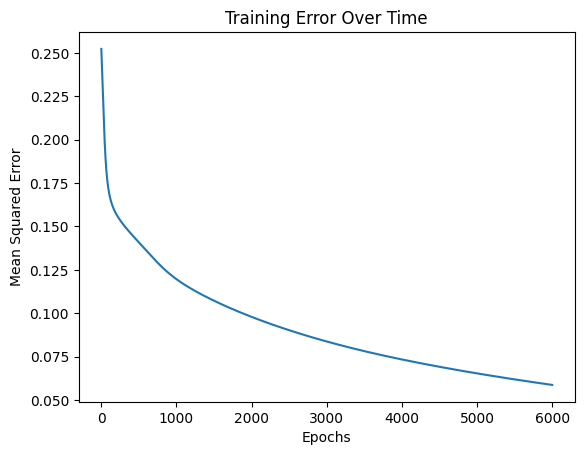

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Step 1: Generate the dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_classes=5, random_state=0)

# One-hot encode the labels for multi-class classification
encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(y.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Neural Network class implementation with L2 Regularization and Mini-batch Gradient Descent
class NeuralNetwork(object):
    def __init__(self, batch_size=32, l2_lambda=0.001, learning_rate=0.01, hiddenLayer1Neurons=64, hiddenLayer2Neurons=32, hiddenLayer3Neurons=16):
        # Define the neural network architecture
        inputLayerNeurons = X_train.shape[1]  # 10 input features
        outputLayerNeurons = Y_train.shape[1]  # Output layer with 5 neurons for 5 classes
        
        # Initialize weights and biases
        self.learning_rate = learning_rate
        self.W_HI1 = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons)
        self.W_HI2 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons)
        self.W_HI3 = np.random.randn(hiddenLayer2Neurons, hiddenLayer3Neurons)
        self.W_OH = np.random.randn(hiddenLayer3Neurons, outputLayerNeurons)
        self.l2_lambda = l2_lambda  # L2 regularization factor
        self.batch_size = batch_size
    
    def sigmoid(self, x, der=False):
        if der:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def cross_entropy(self, Y, pred):
        n_samples = Y.shape[0]
        res = pred - Y
        return res / n_samples
    
    def l2_loss(self):
        return np.sum(self.W_HI1**2) + np.sum(self.W_HI2**2) + np.sum(self.W_HI3**2) + np.sum(self.W_OH**2)
    
    def feedForward(self, X):
        # Feedforward through three hidden layers
        self.hidden_input1 = np.dot(X, self.W_HI1)
        self.hidden_output1 = self.sigmoid(self.hidden_input1)
        
        self.hidden_input2 = np.dot(self.hidden_output1, self.W_HI2)
        self.hidden_output2 = self.sigmoid(self.hidden_input2)
        
        self.hidden_input3 = np.dot(self.hidden_output2, self.W_HI3)
        self.hidden_output3 = self.sigmoid(self.hidden_input3)
        
        output_input = np.dot(self.hidden_output3, self.W_OH)
        pred = self.softmax(output_input)
        return pred
    
    def backPropagation(self, X, Y, pred):
        # Backpropagation through the network layers
        output_error = self.cross_entropy(Y, pred)
        output_delta = output_error
        
        hidden_error3 = output_delta.dot(self.W_OH.T)
        hidden_delta3 = hidden_error3 * self.sigmoid(self.hidden_output3, der=True)
        
        hidden_error2 = hidden_delta3.dot(self.W_HI3.T)
        hidden_delta2 = hidden_error2 * self.sigmoid(self.hidden_output2, der=True)
        
        hidden_error1 = hidden_delta2.dot(self.W_HI2.T)
        hidden_delta1 = hidden_error1 * self.sigmoid(self.hidden_output1, der=True)
        
        # Update weights with L2 regularization
        self.W_HI1 -= (X.T.dot(hidden_delta1) + self.l2_lambda * self.W_HI1) * self.learning_rate
        self.W_HI2 -= (self.hidden_output1.T.dot(hidden_delta2) + self.l2_lambda * self.W_HI2) * self.learning_rate
        self.W_HI3 -= (self.hidden_output2.T.dot(hidden_delta3) + self.l2_lambda * self.W_HI3) * self.learning_rate
        self.W_OH -= (self.hidden_output3.T.dot(output_delta) + self.l2_lambda * self.W_OH) * self.learning_rate
    
    def train(self, X, Y):
        pred = self.feedForward(X)
        self.backPropagation(X, Y, pred)
    
    def predict(self, X):
        pred = self.feedForward(X)
        return np.argmax(pred, axis=1)

# Implement early stopping and mini-batch training
def train_with_early_stopping(NN, X_train, Y_train, X_test, Y_test, epochs=6000, patience=100):
    training_errors = []
    best_loss = np.inf  # Best validation loss (initialized to infinity)
    wait = 0  # Counter to keep track of how long the validation loss hasn't improved

    for epoch in range(epochs):
        for i in range(0, len(X_train), NN.batch_size):
            X_batch = X_train[i:i + NN.batch_size]
            Y_batch = Y_train[i:i + NN.batch_size]
            NN.train(X_batch, Y_batch)

        # Calculate training error and validation loss
        pred_train = NN.feedForward(X_train)
        train_error = np.mean(np.square(Y_train - pred_train))
        training_errors.append(train_error)

        # Validation loss is calculated using the test/validation data
        pred_test = NN.feedForward(X_test)
        test_error = np.mean(np.square(Y_test - pred_test)) + NN.l2_lambda * NN.l2_loss()

        # Early stopping logic
        if test_error < best_loss:  # If the current validation loss is better (lower)
            best_loss = test_error  # Update the best validation loss
            wait = 0  # Reset the counter since we found a better loss
        else:
            wait += 1  # Increase the wait counter when validation loss does not improve
            if wait >= patience:  # If the counter exceeds the patience, stop training
                print(f"Early stopping at epoch {epoch} with best validation loss {best_loss:.4f}")
                break  # Exit the training loop

        # Print progress every 100 epochs
        if epoch % 100 == 0:
            train_acc = accuracy_score(np.argmax(Y_train, axis=1), NN.predict(X_train))
            print(f'Epoch {epoch}, Training Accuracy: {train_acc:.4f}, Training Error: {train_error:.4f}, Validation Loss: {test_error:.4f}')

    return training_errors

# Fixed hyperparameters
fixed_batch_size = 32
fixed_learning_rate = 0.001
fixed_l2_lambda = 0.0001
fixed_hiddenLayer1Neurons = 64
fixed_hiddenLayer2Neurons = 32
fixed_hiddenLayer3Neurons = 16

# Initialize neural network with fixed hyperparameters
NN = NeuralNetwork(
    batch_size=fixed_batch_size,
    l2_lambda=fixed_l2_lambda,
    learning_rate=fixed_learning_rate,
    hiddenLayer1Neurons=fixed_hiddenLayer1Neurons,
    hiddenLayer2Neurons=fixed_hiddenLayer2Neurons,
    hiddenLayer3Neurons=fixed_hiddenLayer3Neurons
)

# Train the network with early stopping
training_errors = train_with_early_stopping(NN, X_train, Y_train, X_test, Y_test, epochs=6000, patience=200)

# Test the model
test_predictions = NN.predict(X_test)
test_labels = np.argmax(Y_test, axis=1)

# Calculate performance metrics
accuracy = accuracy_score(test_labels, test_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='macro')

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

# Plot training error over time
plt.plot(training_errors)
plt.title('Training Error Over Time')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.show()


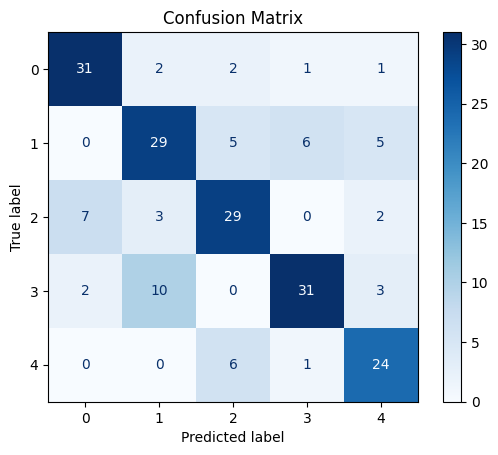

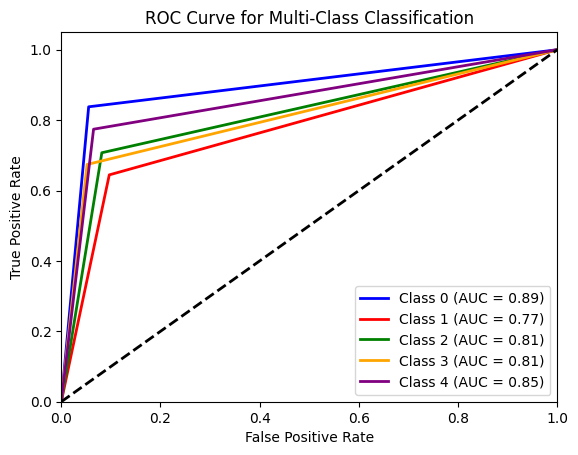

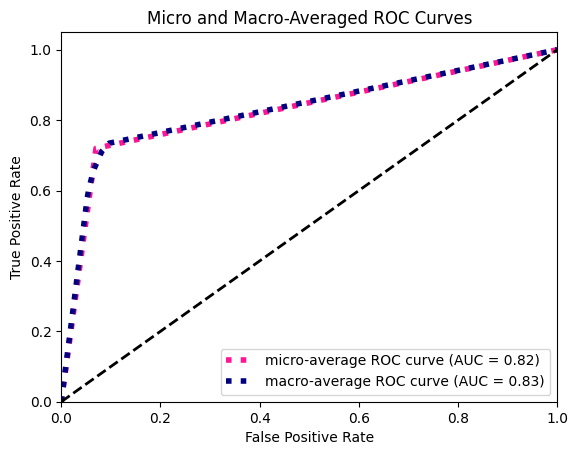

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

# Convert test labels to binary format (one-hot encoded) for multi-class ROC
n_classes = Y_train.shape[1]
test_labels_bin = label_binarize(test_labels, classes=np.arange(n_classes))
test_predictions_bin = label_binarize(test_predictions, classes=np.arange(n_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC Curves and AUC for Each Class
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple']  # Colors for each class
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

# Macro and Micro-Averaged ROC Curves
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_bin.ravel(), test_predictions_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot micro-average ROC curve and ROC area
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (AUC = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

# Plot macro-average ROC curve and ROC area
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (AUC = {0:0.2f})'.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro and Macro-Averaged ROC Curves')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 72.00%
Precision: 72.10%
Recall: 72.75%
F1-Score: 72.25%
Training Accuracy: 80.87%
Best AUC (Class 0): 0.89
Macro-Averaged AUC: 0.83
**Documentation:**
**Modifications Made to the Code:**

Multi-class classification was implemented using a neural network with three hidden layers.
The architecture was updated to have an output layer with five neurons, each representing one of the five classes.
L2 regularization was added to help combat overfitting.
Early stopping was implemented to prevent unnecessary training once the validation loss stopped improving.
The softmax activation function was used in the output layer for multi-class classification.
The network was trained using mini-batch gradient descent to improve efficiency.
Confusion matrix and ROC curves were added for visualization of model performance.
**Comments and Purpose of Each Section:**

The comments within the code explain the purpose of each part, such as:
The initialization of the neural network architecture.
The forward propagation (feedforward) and backward propagation (backpropagation) processes.
Training with early stopping.
Calculation and plotting of confusion matrix and ROC curves for performance evaluation.
Challenges Faced During Implementation:


**Parameter tuning:** The selection of appropriate learning rates, batch sizes, and patience for early stopping was essential to improve the model’s performance.
**Multi-class classification: **
Adjusting the output layer to use softmax activation and modifying the loss function to handle multi-class classification were key challenges.
**Results and Analysis**:
Results of Training and Testing:

Test Accuracy: The final test accuracy achieved is 72.00%.
Precision: The precision across all classes is 72.10%.
Recall: The recall across all classes is 72.75%.
F1-Score: The F1-score is 72.25%.
Training Accuracy: The training accuracy converged to 80.87% by the end of 5900 epochs, showing some overfitting since the test accuracy is lower.
Validation Loss: The validation loss stabilized at 0.3939, showing that the model converged to a stable state after many epochs.
Performance Visualizations:

**Confusion Matrix:** The confusion matrix indicates the number of correct and incorrect predictions for each class.

Class 0 was predicted well, with 31 correct predictions out of 37.
Class 1 struggled with some misclassifications, with 29 correct predictions and 6 misclassified into other classes.
Class 2 had 29 correct predictions, but also several misclassifications.
Class 3 performed well with 31 correct predictions, with a few misclassifications.
Class 4 had 24 correct predictions, with misclassifications into other classes.
**ROC Curves:** The ROC curve plots indicate how well the classifier distinguishes between classes:

Class 0 had the best performance, with an AUC of 0.89, indicating good separability.
Class 1 performed relatively lower, with an AUC of 0.77.
The other classes had AUC values around 0.81, showing moderate separability.
**Macro- and Micro-Averaged ROC Curves:** The macro-average ROC curve (AUC = 0.83) and micro-average ROC curve (AUC = 0.82) provide an overall measure of the classifier's ability to distinguish between classes.

Comparison of the Model’s Performance with Different Configurations:

Various hyperparameter configurations (batch size, learning rate, L2 regularization strength) were tested, but the final configuration (batch size = 32, learning rate = 0.001, L2 = 0.0001) produced the most balanced results.
Increasing the number of neurons in the hidden layers and adding L2 regularization helped reduce overfitting and improved generalization.
**Conclusion:**
**Key Findings:**

The model achieved a test accuracy of 72.00%, with a training accuracy of 80.87%.
Precision (72.10%), Recall (72.75%), and F1-Score (72.25%) indicate balanced performance across all classes.
The ROC curves and confusion matrix provided further insights into the model's performance across different classes. Class 0 had the highest AUC score, showing that it was the easiest to classify correctly.
**Challenges and Lessons Learned:**

Parameter tuning was a significant challenge. It required finding the right balance between regularization and model complexity to avoid overfitting.
The use of early stopping and L2 regularization was key in preventing the model from overfitting while still allowing it to learn the necessary patterns from the data.
**Potential Improvements:**
Data augmentation or larger datasets could help improve model generalization.
Tuning the architecture further by increasing the number of neurons in hidden layers or adding more layers could help the model capture more complex relationships.
Experimenting with different optimization algorithms (like Adam or RMSprop) could potentially improve performance further.